In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.drive_and_act_keypoint_dataset import DriveAndActKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path


pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/drive_and_act/')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
# ------------
# saved model path
# ------------
pretrained_model_path = './saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/'
with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
    checkpoint_path = f.readline()


Global seed set to 1234


In [2]:
def run_experiment(
    train_actors,
    val_actors,
    test_actors,
    is_plot_gt_skeleton=False
):
    lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_hip=True)
    lit_model.load_from_checkpoint(checkpoint_path)
    train_dataset = DriveAndActKeypointDataset(
        prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
        annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
        image_width=image_width,
        image_height=image_height,
        actors=train_actors,
        exclude_ankle=True,
        exclude_hip=True
    )
    val_dataset = DriveAndActKeypointDataset(
        prediction_file=(keypoint_2d_path / 'keypoint_detection_val.json').as_posix(),
        annotation_file=(keypoint_3d_path / 'person_keypoints_val.json').as_posix(),
        image_width=image_width,
        image_height=image_height,
        actors=val_actors,
        exclude_ankle=True,
        exclude_hip=True
    )
    test_dataset = DriveAndActKeypointDataset(
        prediction_file=(keypoint_2d_path / 'keypoint_detection_test.json').as_posix(),
        annotation_file=(keypoint_3d_path / 'person_keypoints_test.json').as_posix(),
        image_width=image_width,
        image_height=image_height,
        actors=test_actors,
        exclude_ankle=True,
        exclude_hip=True
    )

    print(
        'train_dataset', len(train_dataset),
        'val_dataset', len(val_dataset),
        'test_dataset', len(test_dataset)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)

    model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=early_stopping_patience)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    saved_model_path = './saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model'
    if not os.path.exists(saved_model_path):
        os.makedirs(saved_model_path)
    trainer = pl.Trainer(
        # max_steps=10,
        max_epochs=max_epoch,
        callbacks=[model_checkpoint, early_stopping],
        accelerator=device,
        check_val_every_n_epoch=val_check_period,
        default_root_dir=saved_model_path,
        gradient_clip_val=1.0
    )
    trainer.fit(lit_model, train_loader, val_loader)
    with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
        f.writelines(model_checkpoint.best_model_path)
    best_checkpoint_path = model_checkpoint.best_model_path
    trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)
    # plot_samples(
    #     dataset_root_path,
    #     trainer.model,
    #     test_loader,
    #     'test',
    #     img_figsize=(20, 10),
    #     img_width=image_width,
    #     img_height=image_height,
    #     plot_figsize=(20.5, 10),
    #     sample_idices=[1000, 2500, 6000],
    #     is_plot_gt_skeleton=is_plot_gt_skeleton
    # )

## Fine-Tuned with 1 Actors

'Actor: vp1'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


train_dataset 2651 val_dataset 5103 test_dataset 8414


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 2893.4974670410156


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 205 batches: 2234.6983304837854
val MPJPE from: 5056 samples : 644.3125605583191


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Restoring states from the checkpoint path at saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model/lightning_logs/version_9/checkpoints/epoch=4-step=205.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model/lightning_logs/version_9/checkpoints/epoch=4-step=205.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 677.2742472107857
PJPE
                      PJPE
nose            655.824452
left_eye        513.607936
right_eye       606.695031
left_ear        260.729656
right_ear       434.866839
left_shoulder   657.570174
right_shoulder  580.776220
left_elbow      555.538481
right_elbow     469.948655
left_wrist      530.687668
right_wrist     418.237027
left_hip        643.606970
right_hip       798.145042
activities_mpjpe:
{}
test mpjpe: 677.2742472107857


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │     677.2742472107857     │
└───────────────────────────┴───────────────────────────┘

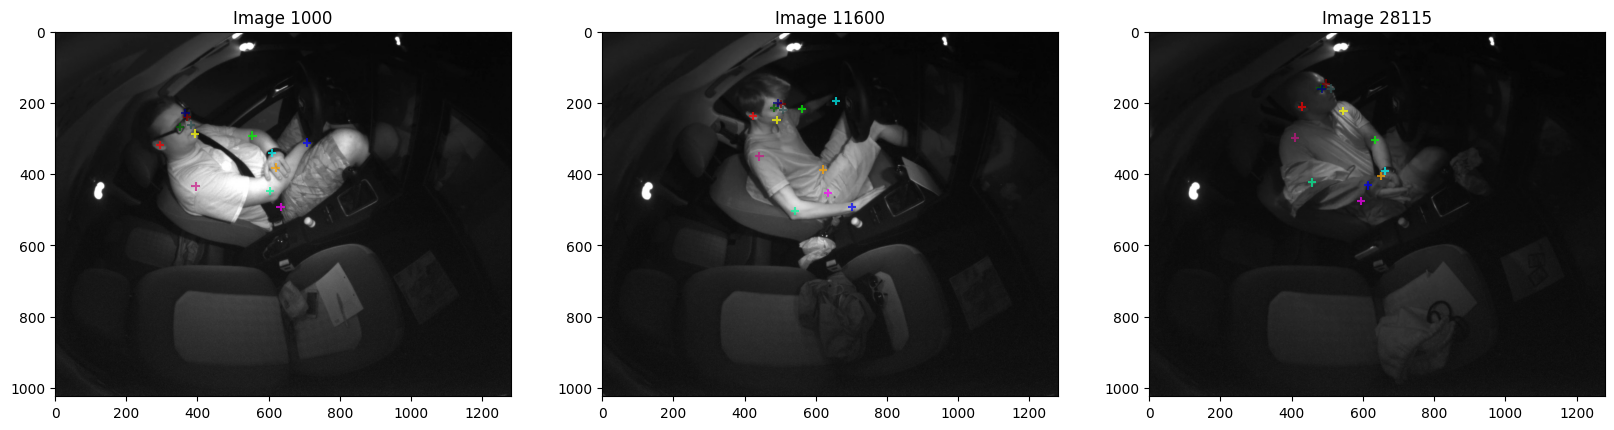

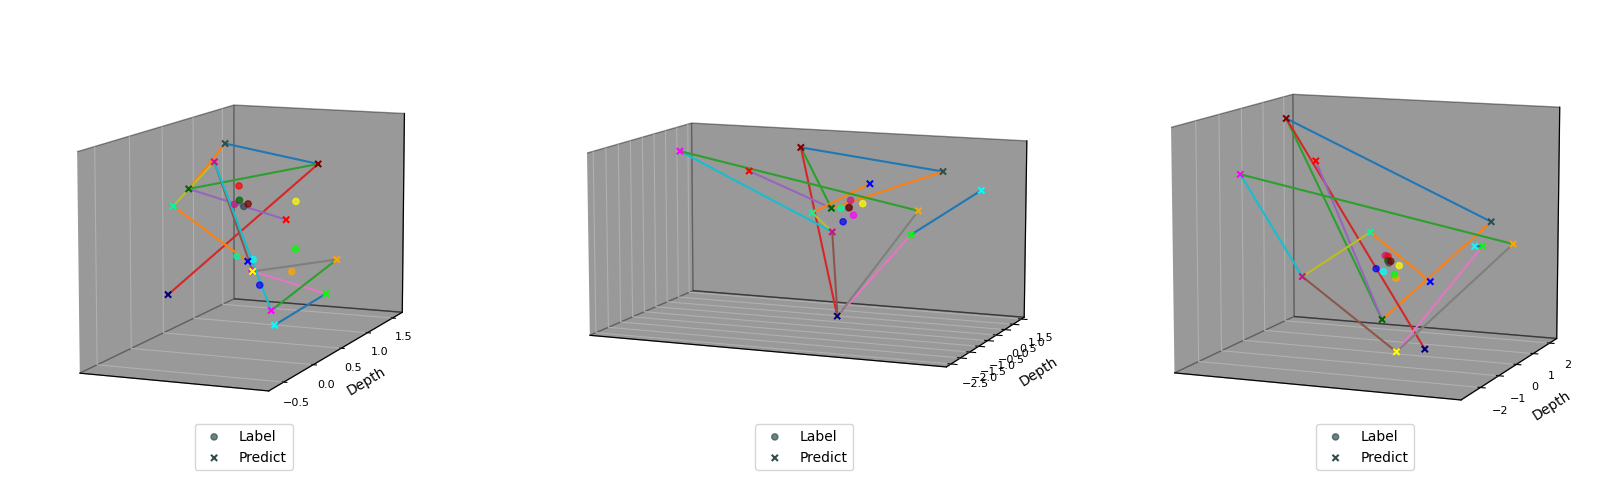

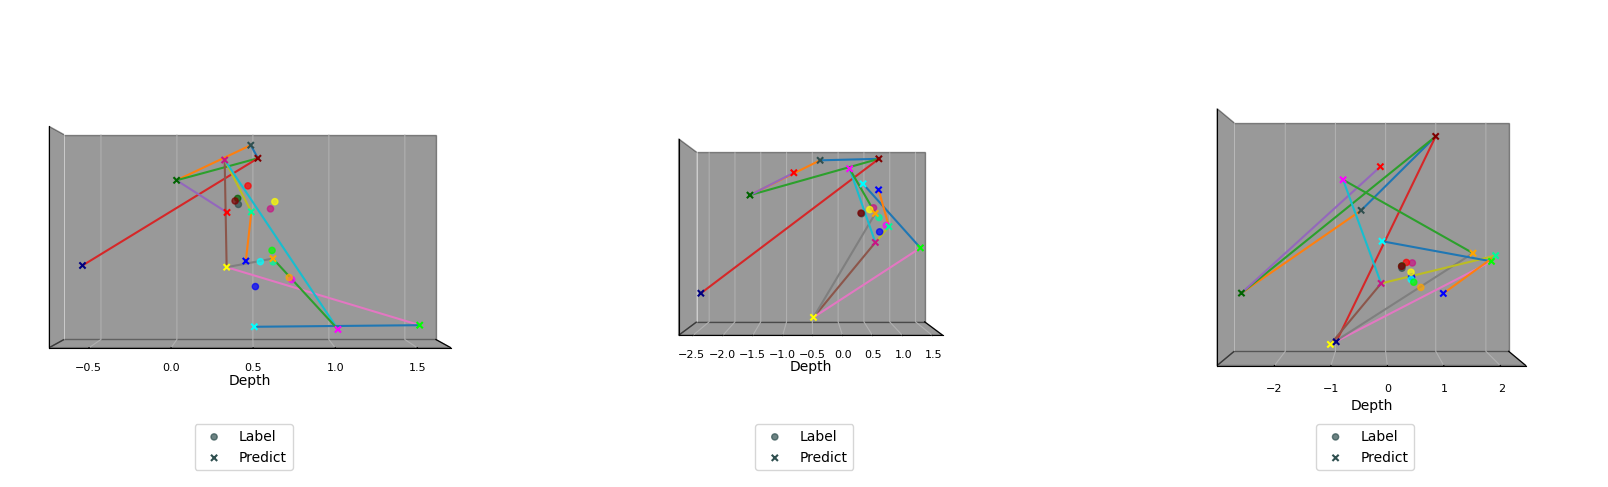

In [3]:
# for vp in ['vp1', 'vp2', 'vp3', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8', 'vp9', 'vp10']:
for vp in ['vp1']:
    display(f'Actor: {vp}')
    run_experiment(
        train_actors=[vp],
        val_actors=['vp11', 'vp12'],
        test_actors=['vp13', 'vp14', 'vp15'],
        is_plot_gt_skeleton=False
    )

## Fine-Tuned with 2 Actors

## Fine-Tuned with 5 Actors

## Fine-Tuned with full dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


train_dataset 2651 val_dataset 5103 test_dataset 8414


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 2753.326416015625


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 205 batches: 2223.0710686706916
val MPJPE from: 5056 samples : 643.3465480804443


Validation: 0it [00:00, ?it/s]

check #2
training loss from 205 batches: 1091.3864946946865
val MPJPE from: 5056 samples : 364.9373948574066


Validation: 0it [00:00, ?it/s]

check #3
training loss from 205 batches: 658.3194937647843
val MPJPE from: 5056 samples : 251.10110640525818


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Restoring states from the checkpoint path at saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model/lightning_logs/version_10/checkpoints/epoch=14-step=615.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model/lightning_logs/version_10/checkpoints/epoch=14-step=615.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 236.03870002088934
PJPE
                      PJPE
nose            191.000496
left_eye        162.416594
right_eye       201.316877
left_ear        136.530287
right_ear       192.647396
left_shoulder   197.741102
right_shoulder  222.443958
left_elbow      218.510656
right_elbow     213.222755
left_wrist      200.281284
right_wrist     210.719435
left_hip        199.441735
right_hip       209.205052
activities_mpjpe:
{}
test mpjpe: 236.03870002088934


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │    236.03870002088934     │
└───────────────────────────┴───────────────────────────┘

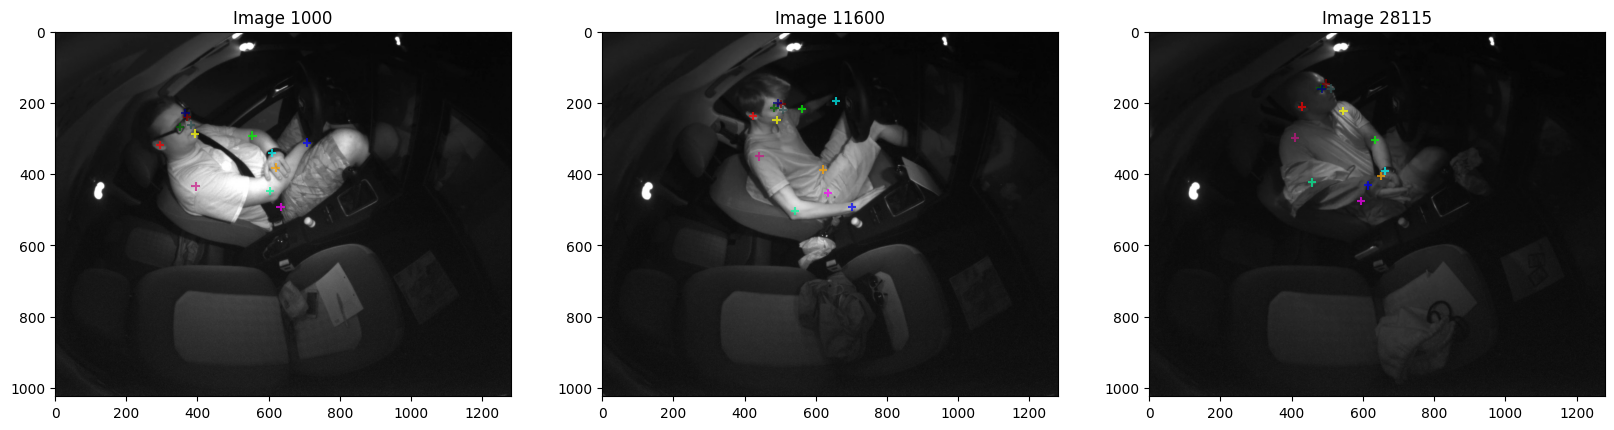

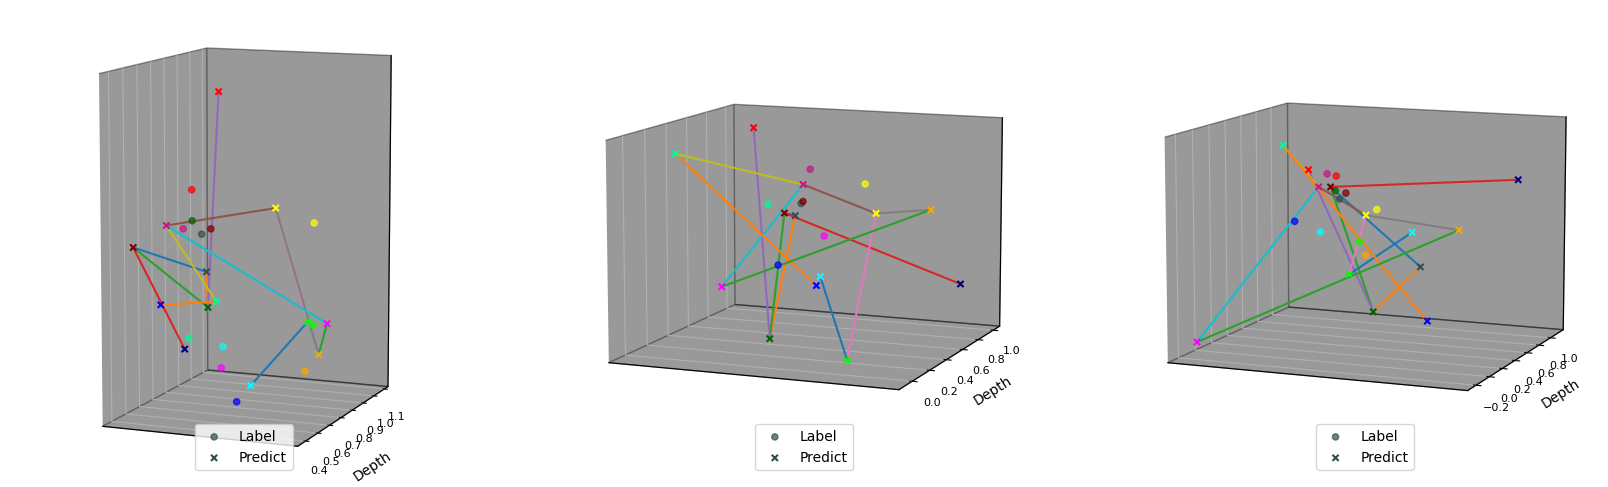

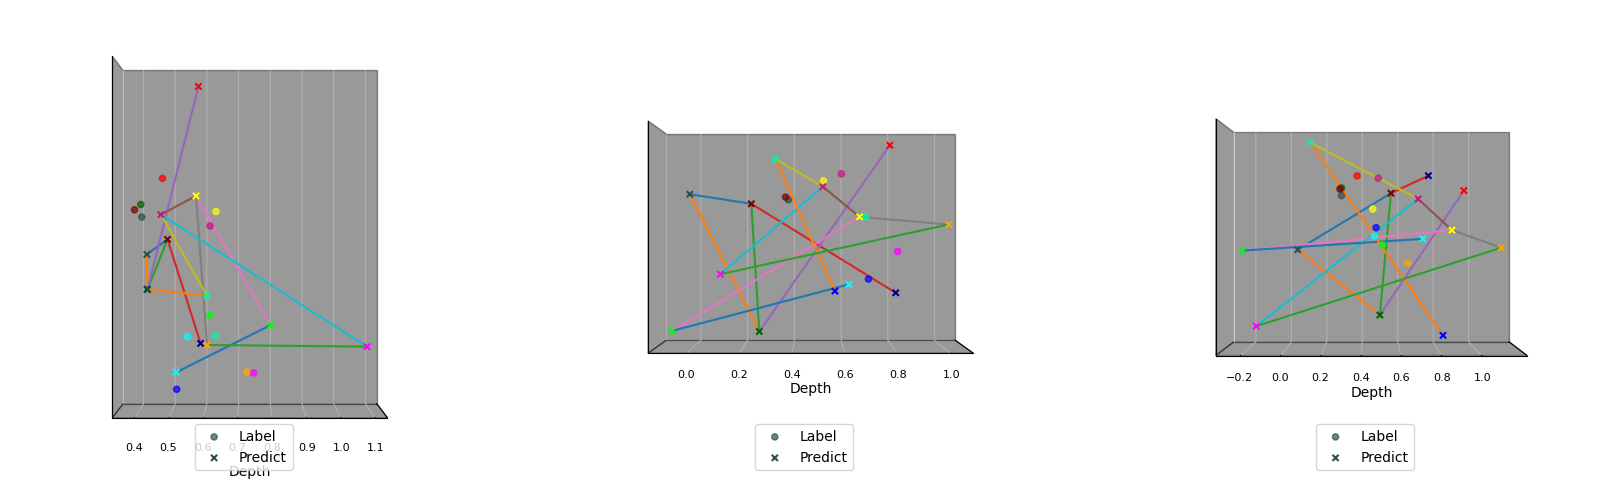

In [4]:
run_experiment(
    train_actors=[vp],
    val_actors=['vp11', 'vp12'],
    test_actors=['vp13', 'vp14', 'vp15'],
    is_plot_gt_skeleton=False
)